# Image Classification 
___

#### Background

The first model was based on the data cumulatively collected to be split between clean and dirty.  No segmentation was made to the specifics of the image.  Many images contain piping, ladders, hatch covers, tank tops, and or focused on people.

In this notebook, the model will focus on a narrowed dataset to just images of bulkheads.  These images were copied to a new directory called selective_data.  It was subdivided into a validation set (10%) and training set (90%).
___

In [76]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
import pandas as pd
import shutil
import os
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, smart_resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

___
#### Data Pre-processing

This project is working with an imbalanced and small dataset.  There are some preprocessing steps to take to improve the model performance.  These steps can be tailored in the future as the dataset size increases.

* Splitting
* Image Augmentation
* Image Generator

Before creating synthetic images to balance out the dataset, we will hold back 10% for a test set of unaltered images.  This will be based on 10% of the dirty images, the target number for balancing the minority dataset.  This is a relatively large set, 20% of the clean images, but this will eliminate overstating or understating the evaluation of the model.  In time this will not be as significant as te dataset is natually balanced out.
___



In [48]:
clean_path = '../data/selective_data/train/clean/'
clean_images = [i for i in os.listdir(clean_path)]

dirty_path = '../data/selective_data/train/dirty/'
dirty_images = [i for i in os.listdir(dirty_path)]

len(clean_images), len(dirty_images)

(250, 340)

In [49]:
# Holding back 25 and 34 random images from each class to serve as a test set.

# get ten random clean images
random.shuffle(clean_images)
test_clean_list = clean_images[:25]

# make a filepath
test_clean = []
for image in test_clean_list:
    test_clean.append(clean_path+image)

# move to test directory
for clean_image in test_clean:
    shutil.move(clean_image, '../data/selective_data/test/clean/')

# get ten random dirty images
random.shuffle(dirty_images)
test_dirty_list = dirty_images[:34]

# make a filepath
test_dirty = []
for image in test_dirty_list:
    test_dirty.append(dirty_path+image)

# move to test directory
for dirty_image in test_dirty:
    shutil.move(dirty_image, '../data/selective_data/test/dirty/')

In [52]:
num_clean = len([i for i in os.listdir('../data/selective_data/train/clean/')])
num_dirty = len([i for i in os.listdir('../data/selective_data/train/dirty/')])
num_clean, num_dirty

(225, 306)

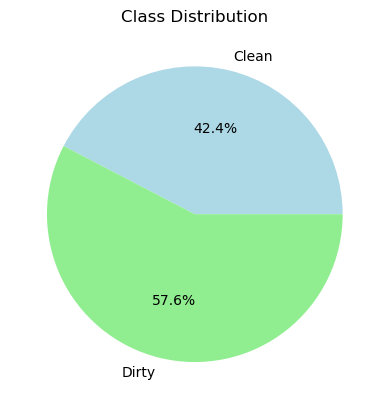

In [53]:
# Pie chart with class distribution
fig, ax = plt.subplots()
ax.pie(x=[num_clean, num_dirty], labels=['Clean', 'Dirty'], colors=['lightblue', 'lightgreen'], autopct='%1.1f%%')
ax.set_title('Class Distribution')
plt.show;

___
#### Modeling

This time thee model 

In [80]:
# create the image data generator to apply to the transformations to data
# the transformations are realistic as it relates to what could be seen
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range=(0.7, 1.3),
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

model_target_size = (224, 224)
model_batch_size = 32

# Loading in image data
train_generator = train_datagen.flow_from_directory(
    '../data/selective_data/train/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=27,
)

validation_generator = train_datagen.flow_from_directory(
    '../data/selective_data/train/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=27,
)

Found 479 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [77]:
# model for image classification
model = Sequential()
model.add(Input((224, 224, 3)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# compile model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='bce', metrics=['accuracy', 'AUC', Precision(), Recall()])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_43 (Bat  (None, 111, 111, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_43 (Dropout)        (None, 111, 111, 64)      0         
                                                                 
 conv2d_32 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 54, 54, 64)     

In [78]:
# fit model
class_weights = {0: 0.9, 1: 1.1}
earlystopping = EarlyStopping(restore_best_weights=True, monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='min')
model.fit(train_generator, epochs=20, validation_data=validation_generator, class_weight=class_weights, callbacks=[earlystopping])

Epoch 1/20
15/15 [==============================] - 82s 5s/step - loss: 1.4429 - accuracy: 0.5511 - auc: 0.5849 - precision: 0.6309 - recall: 0.5326 - val_loss: 0.7040 - val_accuracy: 0.5962 - val_auc: 0.5129 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 2/20
15/15 [==============================] - 74s 5s/step - loss: 1.2508 - accuracy: 0.5553 - auc: 0.5950 - precision: 0.6275 - recall: 0.5616 - val_loss: 0.7306 - val_accuracy: 0.5769 - val_auc: 0.6371 - val_precision: 0.5769 - val_recall: 1.0000
Epoch 3/20
15/15 [==============================] - 79s 5s/step - loss: 1.1269 - accuracy: 0.6117 - auc: 0.6608 - precision: 0.6731 - recall: 0.6341 - val_loss: 0.7008 - val_accuracy: 0.5769 - val_auc: 0.5045 - val_precision: 0.5769 - val_recall: 1.0000
Epoch 4/20
15/15 [==============================] - 81s 5s/step - loss: 1.1723 - accuracy: 0.6159 - auc: 0.6556 - precision: 0.6917 - recall: 0.6014 - val_loss: 0.7865 - val_accuracy: 0.5769 - val_auc: 0.4644 - val_precision: 0.5769 - val

In [171]:
model.save('../assets/saved_models/second_best_model')

INFO:tensorflow:Assets written to: ../assets/saved_models/second_best_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/second_best_model\assets


___
#### Predictions
Let's see how the model does on the test set.  The test set will need to be resaled.
___


In [95]:
def make_predictions(path):
    """Generate predictions for a dataset given its path.
    The dataset should be organized in a directory into subdirectories labelling the classes"""
    test_datagen = ImageDataGenerator(
        rescale=1./255 # This is a necessary preprocessing step
    )
    test_generator = test_datagen.flow_from_directory(
        path,
        target_size=model_target_size,
        batch_size=model_batch_size,
        class_mode=None,
        shuffle=False
    )
   
    predictions = model.predict(test_generator, verbose=1)
    predicted_class = np.argmax(predictions, axis=1)
    for image, pred_class in enumerate(predicted_class):
        print(f'Image {image+1} predicted as class: {pred_class}')

    return test_generator.classes
    

In [96]:
make_predictions('../data/selective_data/test/')

Found 59 images belonging to 2 classes.
2/2 [==============================] - 6s 2s/step
Image 1 predicted as class: 0
Image 2 predicted as class: 0
Image 3 predicted as class: 0
Image 4 predicted as class: 0
Image 5 predicted as class: 0
Image 6 predicted as class: 0
Image 7 predicted as class: 0
Image 8 predicted as class: 0
Image 9 predicted as class: 0
Image 10 predicted as class: 0
Image 11 predicted as class: 0
Image 12 predicted as class: 0
Image 13 predicted as class: 0
Image 14 predicted as class: 0
Image 15 predicted as class: 0
Image 16 predicted as class: 0
Image 17 predicted as class: 0
Image 18 predicted as class: 0
Image 19 predicted as class: 0
Image 20 predicted as class: 0
Image 21 predicted as class: 0
Image 22 predicted as class: 0
Image 23 predicted as class: 0
Image 24 predicted as class: 0
Image 25 predicted as class: 0
Image 26 predicted as class: 0
Image 27 predicted as class: 0
Image 28 predicted as class: 0
Image 29 predicted as class: 0
Image 30 predicted a

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [93]:
true_labels = test_generator.classes

NameError: name 'test_generator' is not defined